In [1]:
import os, glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import cv2
from tensorflow import keras
from keras import backend as K
from keras.losses import CategoricalCrossentropy
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam

from tifffile import imread, imwrite

c:\Users\nwuen\.conda\envs\tensorflow\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [3]:
#Hyperparameter
img_size=400

epochs = 1000
batch_size = 2
patch_size = img_size
num_batches = 50

num_classes = 44
classes = np.arange(num_classes)
scores = [ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 24., 25., 26.,
       27., 28., 30., 32., 33., 34., 36., 38., 39., 40., 42., 45., 48.,
       50., 51., 54., 57., 60.]

#Learningrate Schedule
class MyLRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, initial_learning_rate):
    self.initial_learning_rate = initial_learning_rate
    self.name = 'PolynomialLearningRate'

  def __call__(self, step):
    epoch = step//(num_batches**9999)
    return self.initial_learning_rate*(1 - epoch/epochs)**0.9
  
  def get_config(self):
        return {
            "initial_learning_rate": self.initial_learning_rate,
            "name": self.name,
        }

#Optimizer
optimizer = keras.optimizers.SGD(MyLRSchedule(0.01),momentum=0.99,nesterov=True, name='SGD')

#Loss Function
def combo_loss(targets, prediction):
    
    intersection = K.sum(tf.cast(targets*prediction,tf.float32),axis=(1,2))
    union = (K.sum(targets,axis=(1,2)) + K.sum(prediction,axis=(1,2)))
    dice = 1 - (2./num_classes)*K.sum(intersection/union,axis=1)
    crossentropy = CategoricalCrossentropy()(targets,prediction)

    return dice + crossentropy

In [4]:
def load_label(path_to_label):

    label = cv2.resize(imread(path_to_label),(img_size,img_size),interpolation = cv2.INTER_NEAREST)
    
    for i, score in enumerate(scores):
        label[label == score] = i

    label = to_categorical(label,num_classes)

    return label

In [5]:
def load_training_data(img_names,label_names):
    
    # Initalise mini batch
    images = np.zeros((len(img_names),patch_size,patch_size,3))
    labels = np.zeros((len(label_names),patch_size,patch_size,num_classes))

    for i, (img_name, label_name) in enumerate(zip(img_names, label_names)):

        #x = random.randint(0,800-patch_size)
        #y = random.randint(0,800-patch_size)

        # append label
        labels[i] = load_label(label_name)

        # append image
        new_img = cv2.resize(cv2.imread(img_name),(400,400)).astype(np.float32)
        new_img -= np.mean(new_img)
        new_img /= np.var(new_img)
        images[i] = new_img
        

    return images, labels

In [6]:
#Training Data
train_img_path = 'C:/Users/nwuen/Documents/deepdart_aml/dataset/train'
train_label_path = 'T:/deepdart_data/train'


    # get filenames
train_img_names = sorted(glob.glob(train_img_path+'/**/*'+'.JPG', recursive=True))
train_label_names = sorted(glob.glob(train_label_path+'/**/*'+'.tif', recursive=True))

train_img_list = [train_img_names[i:i + num_batches*batch_size] for i in range(0, len(train_img_names), num_batches*batch_size)]
train_label_list = [train_label_names[i:i + num_batches*batch_size] for i in range(0, len(train_label_names), num_batches*batch_size)]


#Validation Data
val_img_path = 'C:/Users/nwuen/Documents/deepdart_aml/dataset/val'
val_label_path = 'T:/deepdart_data/val'

    # get filenames
val_img_names = sorted(glob.glob(val_img_path+'/**/*'+'.JPG', recursive=True))
val_label_names = sorted(glob.glob(val_label_path+'/**/*'+'.tif', recursive=True))

val_img_list = [val_img_names[i:i + num_batches*batch_size] for i in range(0, len(val_img_names), num_batches*batch_size)]
val_label_list = [val_label_names[i:i + num_batches*batch_size] for i in range(0, len(val_label_names), num_batches*batch_size)]

In [7]:
from keras.layers import MaxPooling2D, Conv2D, Conv2DTranspose, concatenate ,BatchNormalization, LeakyReLU

Norm = BatchNormalization
LReLU = LeakyReLU
Pool = MaxPooling2D

def NN_UNet():
    with tf.device("cpu:0"):
        inputs = keras.Input(shape=(patch_size,patch_size,3))

        #Downsampeling
        x = Conv2D(32,3,padding='same')(inputs)
        x = Norm()(x)
        x = LReLU(alpha= 0.01)(x)

        x = Conv2D(32,3,padding='same')(x)
        x = Norm()(x)
        l1 = LReLU(alpha= 0.01)(x)

        x = Pool(pool_size=2, strides= 2, padding='valid')(l1)

        x = Conv2D(64,3,padding='same')(x)
        x = Norm()(x)
        x = LReLU(alpha= 0.01)(x)

        x = Conv2D(64,3,padding='same')(x)
        x = Norm()(x)
        l2 = LReLU(alpha= 0.01)(x)

        x = Pool(pool_size= 2, strides= 2, padding='valid')(l2)

        x = Conv2D(128,3,padding='same')(x)
        x = Norm()(x)
        x = LReLU(alpha= 0.01)(x)

        x = Conv2D(128,3,padding='same')(x)
        x = Norm()(x)
        l3 = LReLU(alpha= 0.01)(x)
        
        x = Pool(pool_size= 2, strides= 2, padding='valid')(l3)

        x = Conv2D(256,3,padding='same')(x)
        x = Norm()(x)
        x = LReLU(alpha= 0.01)(x)

        x = Conv2D(256,3,padding='same')(x)
        x = Norm()(x)
        l4 = LReLU(alpha= 0.01)(x)

        x = Pool(pool_size= 2, strides= 2, padding='valid')(l4)


        #bottleneck
        x = Conv2D(512,3,padding='same')(x)
        x = Norm()(x)
        x = LReLU(alpha= 0.01)(x)

        x = Conv2D(512,3,padding='same')(x)
        x = Norm()(x)
        l5 = LReLU(alpha= 0.01)(x)
    


        x = Conv2DTranspose(256,3,2,padding='same')(l5)
        x = concatenate([x,l4])
        
        x = Conv2D(256,3,padding='same')(x)
        x = Norm()(x)
        x = LReLU(alpha= 0.01)(x)

        x = Conv2D(256,3,padding='same')(x)
        x = Norm()(x)
        x = LReLU(alpha= 0.01)(x)


        x = Conv2DTranspose(128,3,2,padding='same')(x)
        x = concatenate([x,l3])
        
        x = Conv2D(128,3,padding='same')(x)
        x = Norm()(x)
        x = LReLU(alpha= 0.01)(x)

        x = Conv2D(128,3,padding='same')(x)
        x = Norm()(x)
        x = LReLU(alpha= 0.01)(x)
        

        x = Conv2DTranspose(64,3,2,padding='same')(x)
        x = concatenate([x,l2])

        x = Conv2D(64,3,padding='same')(x)
        x = Norm()(x)
        x = LReLU(alpha= 0.01)(x)

        x = Conv2D(64,3,padding='same')(x)
        x = Norm()(x)
        x = LReLU(alpha= 0.01)(x)


        x = Conv2DTranspose(32,3,2,padding='same')(x)
        x = concatenate([x,l1])

        x = Conv2D(32,3,padding='same')(x)
        x = Norm()(x)
        x = LReLU(alpha= 0.01)(x)

        x = Conv2D(32,3,padding='same')(x)
        x = Norm()(x)
        x = LReLU(alpha= 0.01)(x)


        x = Conv2D(num_classes,1)(x)
        outputs = keras.activations.softmax(x)

        model = keras.Model(inputs,outputs,name='U-Net')
        return model

UNet = NN_UNet()
UNet.summary()


Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 400, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 400, 400, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 400, 400, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [8]:
current_epoch = 0
current_batch = 20

In [ ]:
UNet.load_weights(f'T:/deepdart_data/pixel_20.h5')

In [10]:
UNet.compile(
    loss = combo_loss,
    optimizer = optimizer,
    metrics=["accuracy"]
)

for epoch in range(current_epoch,epochs):
    print(f'=======================Start of Epoch {epoch+1}==========================\n')
    
    for i in range(current_batch,len(train_img_list)):
        #load the data to train and validate
        x_train, y_train = load_training_data(train_img_list[i],train_label_list[i])
        val_i = i % len(val_img_list)
        x_val, y_val = load_training_data(val_img_list[val_i],val_label_list[val_i])
        with tf.device("cpu:0"):
            history = UNet.fit(x=x_train,y=y_train,batch_size=batch_size,epochs=epoch+1,initial_epoch=epoch,verbose=1,validation_data=(x_val,y_val))
        # Log every 5 batches.
        if i % 5 == 0:
            print(f"Progress: {((i + 1) * batch_size*num_batches)}/{len(train_img_names)} Steps")
        if i % 5 ==0:
            UNet.save_weights(f'pixel_{i}.h5')
        del x_train, 
        current_batch +=1
    current_batch = 0
    current_epoch +=1

=======================Start of Epoch 1==========================

50/50 [==============================] - 101s 2s/step - loss: 1.5380 - accuracy: 0.7915 - val_loss: 9.2940 - val_accuracy: 0.4544
Progress: 600/9098 Steps
50/50 [==============================] - 89s 2s/step - loss: 0.9832 - accuracy: 0.9091 - val_loss: 1.9242 - val_accuracy: 0.7377
Progress: 1100/9098 Steps
50/50 [==============================] - 100s 2s/step - loss: 0.8610 - accuracy: 0.9252 - val_loss: 0.9102 - val_accuracy: 0.9192
Progress: 1600/9098 Steps
50/50 [==============================] - 96s 2s/step - loss: nan - accuracy: 0.5987 - val_loss: nan - val_accuracy: 0.5537


MemoryError: Unable to allocate 26.9 MiB for an array with shape (160000, 44) and data type float32

In [11]:
UNet.save_weights(f'T:/deepdart_data/pixel_{i}.h5')

In [25]:
UNet.load_weights("weights_1_85.h5")
UNet.compile(
    loss = combo_loss,
    optimizer = optimizer,
    metrics=["accuracy"]
)
x_val, y_val = load_training_data(val_img_list[0],val_label_list[0])
print(x_val.shape)
val = UNet.predict(x_val)[0]
val = np.argmax(val,axis=2)
for i, score in enumerate(scores):
    val[val==i] = score



(100, 400, 400, 3)
4/4 [==============================] - 14s 3s/step


In [26]:
print(val_img_list[0][0])
print(val_label_list[0][0])

C:/Users/nwuen/Documents/deepdart_aml/dataset/val\DSC_0001.JPG
T:/deepdart_data/val\DSC_0001.tif


NameError: name 'y_train' is not defined

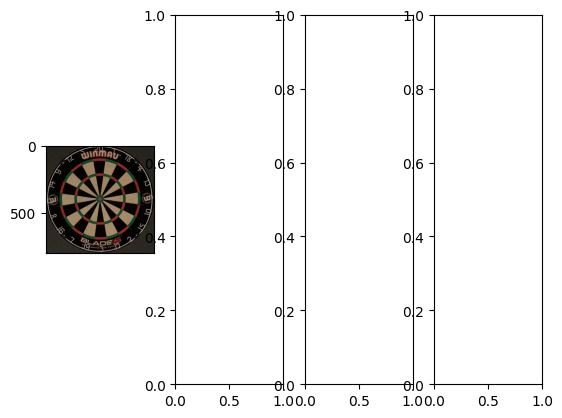

In [27]:
fig, (ax1,ax2,ax3) = plt.subplots(1,4)
ax1.imshow(plt.imread(val_img_list[0][0]))
ax1.get_xaxis().set_visible('off')
ax1.get_yaxis().set_visible('off')
ax1.set_title('Original Image')

ax2.imshow(np.dot(y_val[0],scores),cmap='gray')
ax2.get_xaxis().set_visible('off')
ax2.get_yaxis().set_visible('off')
ax2.set_title('GT Label')

ax3.imshow(val,cmap='gray')
ax3.get_xaxis().set_visible('off')
ax3.get_yaxis().set_visible('off')
ax3.set_title('Prediction')
plt.axis('off')
plt.show()
#imwrite('val.tif',val)

In [11]:
x_train, y_train = load_training_data(train_img_list[0],train_label_list[0])
x_val, y_val = load_training_data(val_img_list[0],val_label_list[0])
train = UNet.predict(x_train)[0]
train = np.argmax(train,axis=2)
for i, score in enumerate(scores):
    train[train==i] = score
test = UNet.predict(x_val)[0]
test = np.argmax(test,axis=2)
for i, score in enumerate(scores):
    test[test==i] = score


4/4 [==============================] - 13s 3s/step


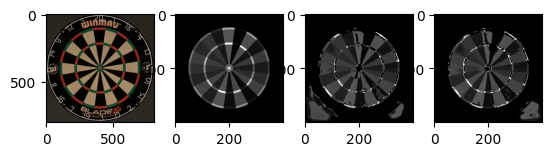

In [11]:
fig, axs = plt.subplots(1,4)
axs[0].imshow(plt.imread('C:/Users/nwuen/Documents/deepdart_aml/dataset/cropped_images/800/d1_02_04_2020/IMG_1081.JPG'))
axs[1].imshow(np.dot(y_train[0],scores),cmap='gray')
axs[2].imshow(train,cmap='gray')
axs[3].imshow(test,cmap='gray')
plt.show()
imwrite('test.tif',train)

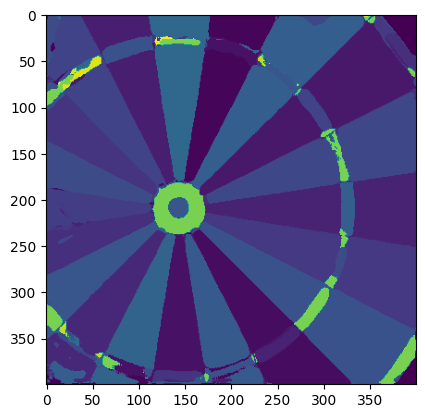

In [ ]:
plt.imshow(train)

In [ ]:
imwrite("train.tif",train)

In [ ]:
import pandas as pd
import os 

pd.read_pickle(f'{os.environ["HOME"]}/Dokumente/deepdart_aml/labelswithscore.pkl')

,img_folder,img_name,bbox,xy,score
0,d1_02_04_2020,IMG_1081.JPG,"[2297, 3949, 676, 2328]","[[0.4350282485875706, 0.1285310734463277], [0....",0.0
1,d1_02_04_2020,IMG_1082.JPG,"[2267, 3803, 759, 2295]","[[0.44162326388888884, 0.12738715277777776], [...",20.0
2,d1_02_04_2020,IMG_1083.JPG,"[2267, 3803, 759, 2295]","[[0.44162326388888884, 0.12738715277777776], [...",29.0
3,d1_02_04_2020,IMG_1084.JPG,"[2267, 3803, 759, 2295]","[[0.44162326388888884, 0.12738715277777776], [...",69.0
4,d1_02_04_2020,IMG_1085.JPG,"[2267, 3803, 759, 2295]","[[0.44162326388888884, 0.12738715277777776], [...",7.0
...,...,...,...,...,...
16045,d2_04_05_2020,DSC_0507.JPG,"[200, 2849, 969, 3618]","[[0.4369087750204756, 0.1419047415543067], [0....",27.0
16046,d2_04_05_2020,DSC_0508.JPG,"[200, 2849, 969, 3618]","[[0.4369087750204756, 0.1419047415543067], [0....",34.0
16047,d2_04_05_2020,DSC_0509.JPG,"[200, 2849, 969, 3618]","[[0.4369087750204756, 0.1419047415543067], [0....",1.0
16048,d2_04_05_2020,DSC_0510.JPG,"[200, 2849, 969, 3618]","[[0.4369087750204756, 0.1419047415543067], [0....",21.0
